In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


In [2]:
train_df = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv',sep=',')
test_df = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv', sep = ',')


train_data = np.array(train_df, dtype = 'float32')
test_data = np.array(test_df, dtype='float32')
X_train = train_data[:,1:]
y_train = np.array(train_data[:,0])
X_test= test_data[:,1:]
y_test=np.array(test_data[:,0])

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [4]:
def preprocess_data(X_train, X_test, eps=1e-8):
    
    # Normalization 
    X_train = X_train/ 255.0
    X_test = X_test/ 255.0

    # Standardization
    # Compute mean and std from TRAINING DATA only
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0) + eps  # Avoid division by zero
    X_train_processed = (X_train - mean) / std
    X_test_processed = (X_test - mean) / std
    
    return X_train_processed, X_test_processed

X_train, X_test = preprocess_data(X_train, X_test)

print("Processed Training Data Shape:", X_train.shape)  # (60000, 784)
print("Processed Test Data Shape:", X_test.shape)       # (10000, 784)

Processed Training Data Shape: (60000, 784)
Processed Test Data Shape: (10000, 784)


In [5]:
# Split before one-hot encoding
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

# One-hot encoding AFTER splitting
num_classes=10
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# Print dataset shapes
print("Training set shape:", x_train.shape, y_train.shape)
print("Validation set shape:", x_val.shape, y_val.shape)
print("Original Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (48000, 784) (48000, 10)
Validation set shape: (12000, 784) (12000, 10)
Original Testing set shape: (10000, 784) (10000, 10)


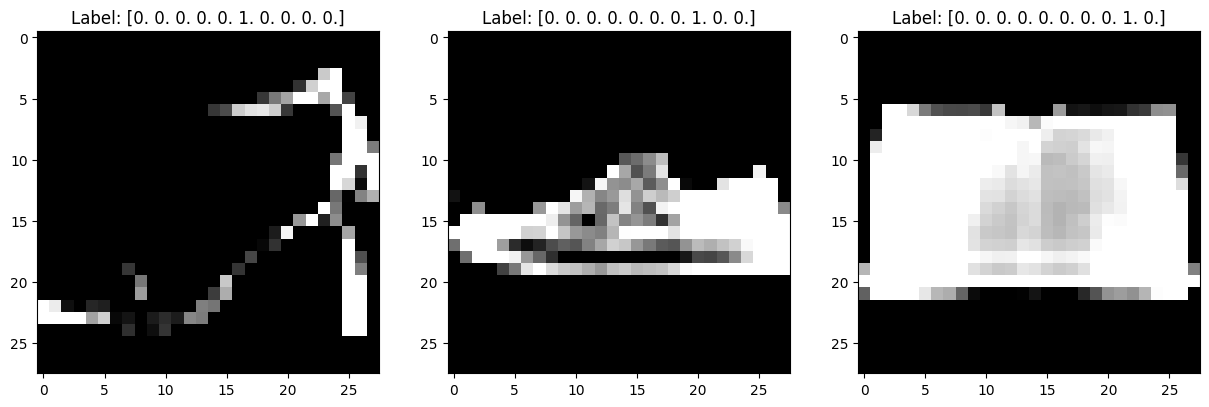

In [6]:
num_images = 3
fig,axes = plt.subplots(1,num_images,figsize=(15,10))
for image,label,ax in zip(x_train[:num_images],y_train[:num_images],axes):
    ax.imshow(image.reshape(28,28),cmap='gray',vmin=0,vmax=1.0)
    ax.set_title(f"Label: {label}")

In [7]:
# Helper Functions

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))
    
def gelu_derivative(x):
    s = np.sqrt(2 / np.pi) * (x + 0.044715 * x**3) 
    tanh_s = np.tanh(s)
    sech2_s = 1 - tanh_s**2 

    return 0.5 * (1 + tanh_s) + 0.5 * x * sech2_s * np.sqrt(2 / np.pi) * (1 + 0.134145 * x**2)

def softmax(x):
    shifted = x - np.max(x, axis=0, keepdims=True)
    exps = np.exp(shifted)
    return exps / np.sum(exps, axis=0, keepdims=True)


def cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-15)) / m
    return loss

def accuracy(y_pred, y_true):
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return np.mean(y_pred_labels == y_true_labels)


In [8]:
class MLP:
    def __init__(self, layer_sizes, activations, dropout_rate=0.0):
        self.layers = []
        self.dropout_rate = dropout_rate
        for i in range(len(layer_sizes) - 1):
            # He initialization for ReLU, Xavier for Tanh
            if activations[i] == 'softmax':
                scale = 0.01  # Smaller scale for softmax layer
            elif activations[i] in ['relu', 'leaky_relu', 'gelu']:
                scale = np.sqrt(2.0 / layer_sizes[i])
            else:
                scale = np.sqrt(1.0 / layer_sizes[i])  # For Tanh/Sigmoid
            W = np.random.randn(layer_sizes[i+1], layer_sizes[i]) * scale
            b = np.zeros((layer_sizes[i+1], 1))
            self.layers.append({
                'W': W,
                'b': b,
                'activation': activations[i]
            })
    
    def forward(self, X, training=True):
        A = X.T  # (input_size, batch_size)
        cache = []
        for layer in self.layers:
            Z = layer['W'] @ A + layer['b']
            activation = layer['activation']
            if activation == 'relu':
                A = relu(Z)
            elif activation == 'leaky_relu':
                A = leaky_relu(Z)
            elif activation == 'tanh':
                A = tanh(Z)
            elif activation == 'gelu':
                A = gelu(Z)
            elif activation == 'softmax':
                A = softmax(Z)
            # Applying dropout (skip for output layer)
            if training and activation != 'softmax' and self.dropout_rate > 0:
                mask = (np.random.rand(*A.shape) < (1 - self.dropout_rate)) / (1 - self.dropout_rate)
                A *= mask
                cache.append({'Z': Z, 'A': A, 'mask': mask})
            else:
                cache.append({'Z': Z, 'A': A})
        return A.T, cache  # (batch_size, output_size), cache
    
    def backward(self, X, y_true, learning_rate, cache):
        y_pred = cache[-1]['A'].T 
        m = y_true.shape[0]
        dZ = (y_pred - y_true).T / m
        
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            layer_cache = cache[i]
            Z = layer_cache['Z']
            A_prev = X.T if i == 0 else cache[i-1]['A']
            
            # gradients for weights/biases
            dW = dZ @ A_prev.T
            db = np.sum(dZ, axis=1, keepdims=True)
            
            # Update parameters
            layer['W'] -= learning_rate * dW
            layer['b'] -= learning_rate * db
            
            # Propagate gradient to previous layer
            if i > 0:
                dA = self.layers[i]['W'].T @ dZ
                # Apply dropout mask if present
                if 'mask' in cache[i-1]:
                    dA *= cache[i-1]['mask']
                # Get Z from the PREVIOUS layer's cache
                Z_prev = cache[i-1]['Z'] 
                # Compute dZ using activation derivative of PREVIOUS layer
                activation = self.layers[i-1]['activation']
                if activation == 'relu':
                    dZ = dA * relu_derivative(Z_prev)  # Use Z_prev
                elif activation == 'leaky_relu':
                    dZ = dA * leaky_relu_derivative(Z_prev) 
                elif activation == 'tanh':
                    dZ = dA * tanh_derivative(Z_prev) 
                elif activation == 'gelu':
                    dZ = dA * gelu_derivative(Z_prev) 


def train_mlp(x_train, y_train, x_val, y_val, layer_sizes, activations, 
              epochs=10, batch_size=64, lr=0.01, dropout_rate=0.0,
              patience=5, delta=0.001):
    
    print(layer_sizes,activations)
    
    mlp = MLP(layer_sizes, activations, dropout_rate)
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    best_val_loss = np.inf
    best_epoch = 0
    wait = 0  # Counter for epochs without improvement for early stopping
    best_model = None  # Store the best model state
    
    for epoch in range(epochs):
        permutation = np.random.permutation(x_train.shape[0])
        x_shuffled = x_train[permutation]
        y_shuffled = y_train[permutation]
        
        epoch_train_loss, epoch_train_acc = 0, 0
        for i in range(0, x_train.shape[0], batch_size):
            X_batch = x_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            y_pred, cache = mlp.forward(X_batch, training=True)
            batch_loss = cross_entropy_loss(y_pred, y_batch)
            batch_acc = accuracy(y_pred, y_batch)
            epoch_train_loss += batch_loss * len(X_batch)
            epoch_train_acc += batch_acc * len(X_batch)
            mlp.backward(X_batch, y_batch, lr, cache)
        
        # Compute training metrics
        epoch_train_loss /= len(x_train)
        epoch_train_acc /= len(x_train)
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # Compute validation metrics
        val_pred, _ = mlp.forward(x_val, training=False)
        val_loss = cross_entropy_loss(val_pred, y_val)
        val_acc = accuracy(val_pred, y_val)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Early stopping logic
        if val_loss < best_val_loss - delta:
            print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}")
            best_val_loss = val_loss
            best_epoch = epoch
            wait = 0
            # Save the best model weights
            best_model = [
                {'W': np.copy(layer['W']), 'b': np.copy(layer['b'])} 
                for layer in mlp.layers
            ]
        else:
            wait += 1
            if wait >= patience:
                print(f"\nEarly stopping at epoch {epoch+1} (best epoch: {best_epoch+1})")
                break  # Exit the training loop
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"Patience: {wait}/{patience}")
    
    # Restore the best model weights
    if best_model is not None:
        for i, layer in enumerate(mlp.layers):
            layer['W'] = best_model[i]['W']
            layer['b'] = best_model[i]['b']
    
    return mlp, train_losses, train_accs, val_losses, val_accs

[784, 128, 10] ['leaky_relu', 'softmax']
Validation loss improved from inf to 0.9451
Epoch 1/200 | Train Loss: 1.4035 | Train Acc: 0.6230 | Val Loss: 0.9451 | Val Acc: 0.7082 | Patience: 0/5
Validation loss improved from 0.9451 to 0.7377
Epoch 2/200 | Train Loss: 0.8466 | Train Acc: 0.7228 | Val Loss: 0.7377 | Val Acc: 0.7490 | Patience: 0/5
Validation loss improved from 0.7377 to 0.6563
Epoch 3/200 | Train Loss: 0.7233 | Train Acc: 0.7493 | Val Loss: 0.6563 | Val Acc: 0.7686 | Patience: 0/5
Validation loss improved from 0.6563 to 0.6083
Epoch 4/200 | Train Loss: 0.6601 | Train Acc: 0.7669 | Val Loss: 0.6083 | Val Acc: 0.7816 | Patience: 0/5
Validation loss improved from 0.6083 to 0.5754
Epoch 5/200 | Train Loss: 0.6190 | Train Acc: 0.7780 | Val Loss: 0.5754 | Val Acc: 0.7933 | Patience: 0/5
Validation loss improved from 0.5754 to 0.5498
Epoch 6/200 | Train Loss: 0.5920 | Train Acc: 0.7879 | Val Loss: 0.5498 | Val Acc: 0.8006 | Patience: 0/5
Validation loss improved from 0.5498 to 0.53

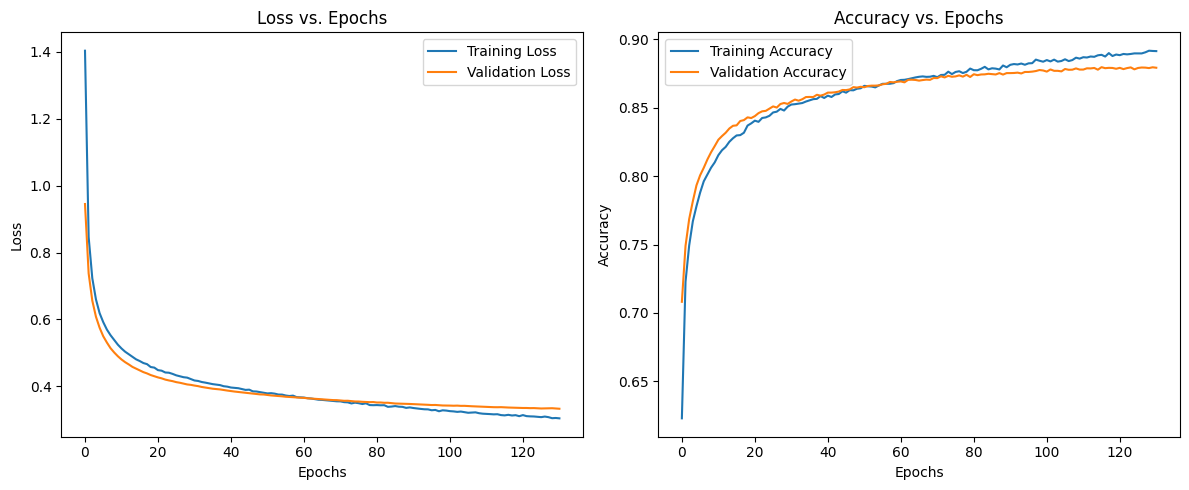

Test Accuracy: 0.8796


In [12]:
layer_sizes = [784, 128, 10]
activations = ['leaky_relu','softmax']
best_mlp, train_loss, train_acc, val_loss, val_acc = train_mlp(
    x_train, y_train, x_val, y_val, 
    layer_sizes, activations, 
    epochs=200,dropout_rate=0.2, lr=0.001,patience=5,batch_size=32
)

import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.tight_layout()
plt.show()

test_pred, _ = best_mlp.forward(X_test, training=False)
test_acc = accuracy(test_pred, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

[784, 400, 250, 100, 10] ['relu', 'relu', 'relu', 'softmax']
Validation loss improved from inf to 0.9693
Epoch 1/200 | Train Loss: 1.5948 | Train Acc: 0.5060 | Val Loss: 0.9693 | Val Acc: 0.6894 | Patience: 0/5
Validation loss improved from 0.9693 to 0.7124
Epoch 2/200 | Train Loss: 0.9344 | Train Acc: 0.6739 | Val Loss: 0.7124 | Val Acc: 0.7446 | Patience: 0/5
Validation loss improved from 0.7124 to 0.6338
Epoch 3/200 | Train Loss: 0.7875 | Train Acc: 0.7175 | Val Loss: 0.6338 | Val Acc: 0.7685 | Patience: 0/5
Validation loss improved from 0.6338 to 0.5891
Epoch 4/200 | Train Loss: 0.7202 | Train Acc: 0.7380 | Val Loss: 0.5891 | Val Acc: 0.7793 | Patience: 0/5
Validation loss improved from 0.5891 to 0.5578
Epoch 5/200 | Train Loss: 0.6755 | Train Acc: 0.7528 | Val Loss: 0.5578 | Val Acc: 0.7911 | Patience: 0/5
Validation loss improved from 0.5578 to 0.5352
Epoch 6/200 | Train Loss: 0.6413 | Train Acc: 0.7663 | Val Loss: 0.5352 | Val Acc: 0.7958 | Patience: 0/5
Validation loss improved

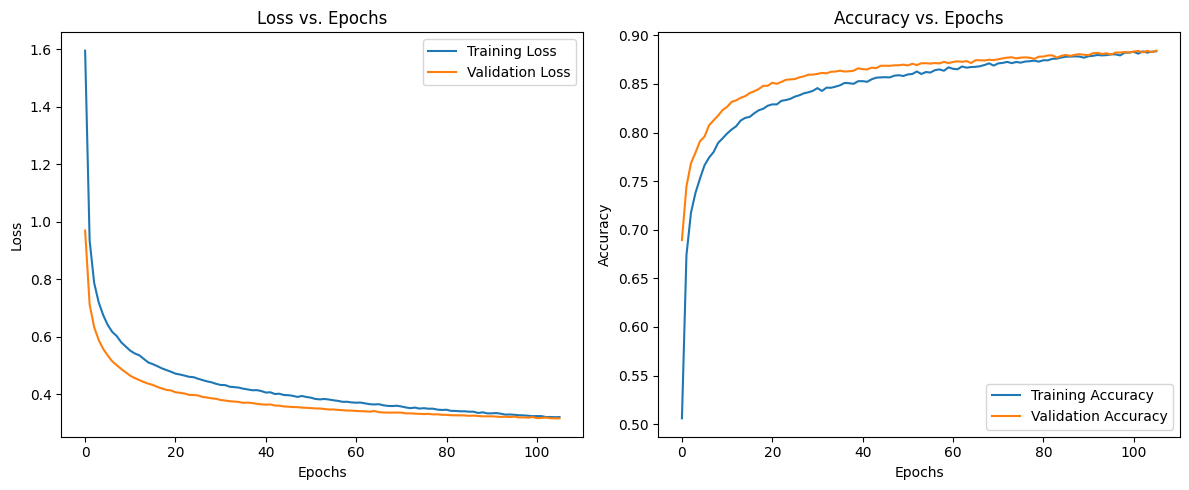

Test Accuracy: 0.8855


In [13]:
layer_sizes = [784, 400, 250, 100, 10]
activations = ['relu', 'relu', 'relu', 'softmax']
best_mlp, train_loss, train_acc, val_loss, val_acc = train_mlp(
    x_train, y_train, x_val, y_val, 
    layer_sizes, activations, 
    epochs=200,dropout_rate=0.2, lr=0.001,patience=5,batch_size=32
)

import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.tight_layout()
plt.show()

test_pred, _ = best_mlp.forward(X_test, training=False)
test_acc = accuracy(test_pred, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

[784, 400, 250, 100, 10] ['gelu', 'gelu', 'gelu', 'softmax']
Validation loss improved from inf to 0.9552
Epoch 1/200 | Train Loss: 1.5978 | Train Acc: 0.5096 | Val Loss: 0.9552 | Val Acc: 0.6949 | Patience: 0/5
Validation loss improved from 0.9552 to 0.7052
Epoch 2/200 | Train Loss: 0.9177 | Train Acc: 0.6770 | Val Loss: 0.7052 | Val Acc: 0.7404 | Patience: 0/5
Validation loss improved from 0.7052 to 0.6312
Epoch 3/200 | Train Loss: 0.7752 | Train Acc: 0.7176 | Val Loss: 0.6312 | Val Acc: 0.7591 | Patience: 0/5
Validation loss improved from 0.6312 to 0.5886
Epoch 4/200 | Train Loss: 0.7117 | Train Acc: 0.7384 | Val Loss: 0.5886 | Val Acc: 0.7711 | Patience: 0/5
Validation loss improved from 0.5886 to 0.5610
Epoch 5/200 | Train Loss: 0.6697 | Train Acc: 0.7518 | Val Loss: 0.5610 | Val Acc: 0.7811 | Patience: 0/5
Validation loss improved from 0.5610 to 0.5374
Epoch 6/200 | Train Loss: 0.6388 | Train Acc: 0.7644 | Val Loss: 0.5374 | Val Acc: 0.7905 | Patience: 0/5
Validation loss improved

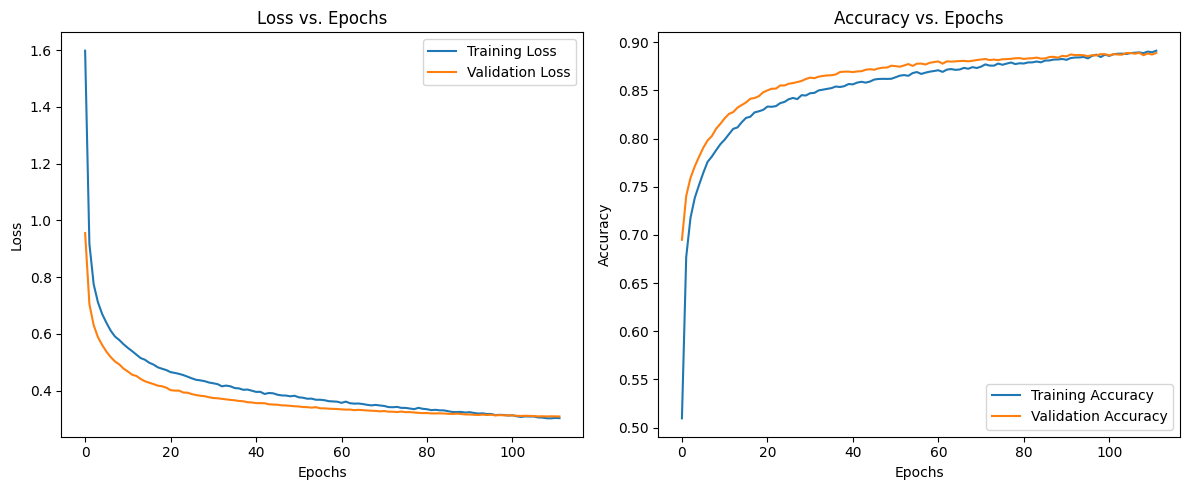

Test Accuracy: 0.8846


In [21]:
layer_sizes = [784, 400, 250, 100, 10]
activations = ['gelu', 'gelu', 'gelu', 'softmax']
best_mlp, train_loss, train_acc, val_loss, val_acc = train_mlp(
    x_train, y_train, x_val, y_val, 
    layer_sizes, activations, 
    epochs=200,dropout_rate=0.2, lr=0.001,patience=5,batch_size=32
)

import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.tight_layout()
plt.show()

test_pred, _ = best_mlp.forward(X_test, training=False)
test_acc = accuracy(test_pred, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

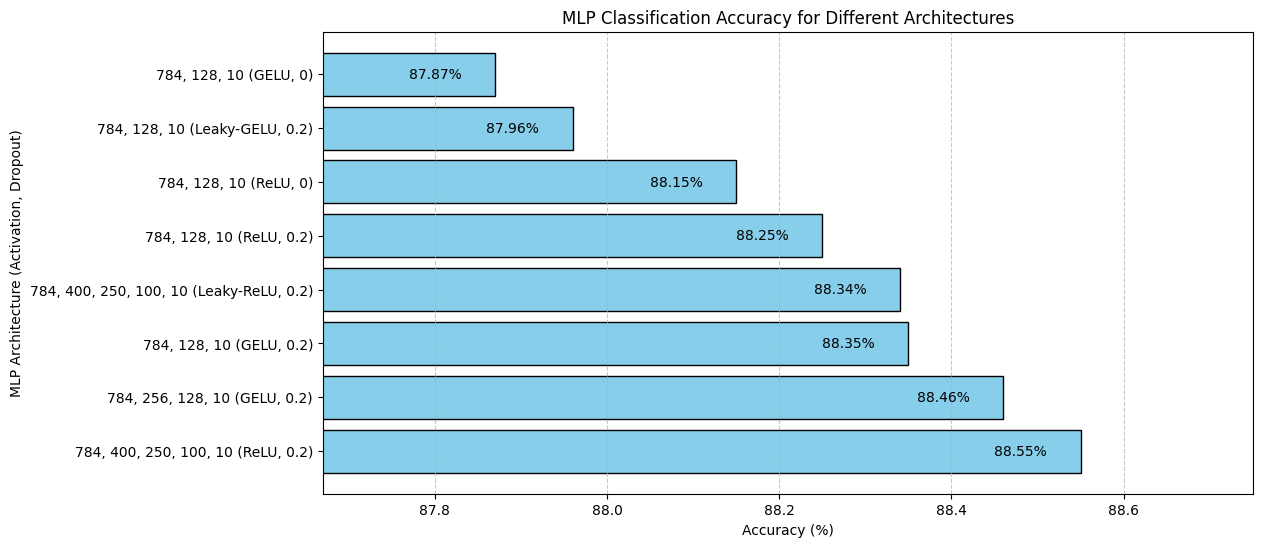

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
architectures = [
    "784, 128, 10 (ReLU, 0.2)",
    "784, 128, 10 (ReLU, 0)",
    "784, 128, 10 (GELU, 0.2)",
    "784, 128, 10 (GELU, 0)",
    "784, 128, 10 (Leaky-GELU, 0.2)",
    "784, 400, 250, 100, 10 (ReLU, 0.2)",
    "784, 400, 250, 100, 10 (Leaky-ReLU, 0.2)",
    "784, 256, 128, 10 (GELU, 0.2)"
]

accuracy = [88.25, 88.15, 88.35, 87.87, 87.96, 88.55, 88.34, 88.46]

# Sort data based on accuracy
sorted_indices = np.argsort(accuracy)
architectures = [architectures[i] for i in sorted_indices]
accuracy = [accuracy[i] for i in sorted_indices]

# Plot settings
plt.figure(figsize=(12, 6))
y_pos = np.arange(len(architectures))
plt.barh(y_pos, accuracy, color='skyblue', edgecolor='black')
plt.yticks(y_pos, architectures)
plt.xlabel('Accuracy (%)')
plt.xlim(min(accuracy) - 0.2, max(accuracy) + 0.2)  # Zoom in on the accuracy range
plt.ylabel('MLP Architecture (Activation, Dropout)')
plt.title('MLP Classification Accuracy for Different Architectures')
plt.gca().invert_yaxis()  # Highest accuracy on top

# Display values on bars
for index, value in enumerate(accuracy):
    plt.text(value - 0.1, index, f"{value:.2f}%", va='center', fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
